# Step -1: Setup

In [1]:
# system/file stuff
import sys
import os
import inspect
from pathlib import Path
import gc
import re
import csv

# datasci stuff
import pandas as pd
import scipy.io
import numpy as np
import random
import hashlib

# computer vision stuff
import cv2
from PIL import Image

# ML stuff
import torch
from tqdm import tqdm # bc i need progress bars
from torch.utils.data import Dataset

# detect face/eye regions of image
import mediapipe as mp

# augmentation
import albumentations as A

# visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Step 0: Establish Dummy Pipeline

In [2]:
itracker_path = Path("/Volumes/Crucial X10/210/GazeCapture/pytorch")
sys.path.append(str(itracker_path)) 

# sanity
print("ITrackerModel.py exists?", (itracker_path / "ITrackerModel.py").exists())
print("checkpoint exists?", (itracker_path / "checkpoint.pth.tar").exists())

ITrackerModel.py exists? True
checkpoint exists? True


In [3]:
# build an empty iTracker network (random weights).”
from ITrackerModel import ITrackerModel
device = "cpu"
model = ITrackerModel().to(device)

In [4]:
# load pretrained weights into model
ckpt = torch.load(itracker_path / "checkpoint.pth.tar", map_location=device)
state = ckpt["state_dict"] if isinstance(ckpt, dict) and "state_dict" in ckpt else ckpt
missing, unexpected = model.load_state_dict(state, strict=False)

In [5]:
# sanity check
print("missing:", missing)
print("unexpected:", unexpected)

missing: []
unexpected: []


In [6]:
model.eval()

B = 1
faces = torch.randn(B, 3, 224, 224, device=device)
eyesL = torch.randn(B, 3, 224, 224, device=device)
eyesR = torch.randn(B, 3, 224, 224, device=device)
faceGrid = torch.randn(B, 25, 25, device=device)  # matches gridSize=25

with torch.no_grad():
    out = model(faces, eyesL, eyesR, faceGrid)

print("out shape:", out.shape)
print("out:", out)

out shape: torch.Size([1, 2])
out: tensor([[ 2.2276, -6.8139]])


# Step 1: Confirm Expected Inputs

Confirm expected inputs: face/left/right tensor shape, dtype, normalization steps (mean images).

This information was used to help create eye2voice/code/ceal_itracker/data.py

In [7]:
mean_face = scipy.io.loadmat(itracker_path / "mean_face_224.mat")["image_mean"]
mean_left = scipy.io.loadmat(itracker_path / "mean_left_224.mat")["image_mean"]
mean_right = scipy.io.loadmat(itracker_path / "mean_right_224.mat")["image_mean"]

print("face:", mean_face.shape, mean_face.dtype, float(mean_face.min()), float(mean_face.max()))
print("left:", mean_left.shape, mean_left.dtype, float(mean_left.min()), float(mean_left.max()))
print("right:", mean_right.shape, mean_right.dtype, float(mean_right.min()), float(mean_right.max()))

face: (224, 224, 3) float32 79.87755584716797 180.56549072265625
left: (224, 224, 3) float32 72.00033569335938 191.53338623046875
right: (224, 224, 3) float32 71.83743286132812 177.91868591308594


# Step 2: Augmentation + Cropping Pipeline

Goal: For each original CEAL image, produce (K+1) iTracker-ready samples:
- face crop (224x224)
- left eye crop (224x224)
- right eye crop (224x224)
- facegrid (625 float vector = 25x25 flattened)
…and record everything in a manifest CSV so the 4 artifacts stay linked.

## Step 2.0: Metadata

1) Walk dataset structure:
   - INPUT_ROOT/{subject_id}/*.jpg
2) Parse filename into fields:
   - subject, distance_m, head_pose_deg, gaze_v_deg, gaze_h_deg
3) Define augmentation count:
   - K = NUM_AUGMENTATIONS
   - aug_id = 0 is unaugmented baseline; 1..K are augmented variants
4) Create an in-memory list of “source images” to process in batches (size=75)

Output: a dataframe/list of source records (one per original image)

In [8]:
# load image metadata
DATA_ROOT = Path("/Volumes/Crucial X10/210/data/columbia_gaze_dataset")

rows = []

# Regex for filename parsing
pattern = re.compile(
    r"(?P<subject>\d+)_"
    r"(?P<distance>\d+)m_"
    r"(?P<head_pose>-?\d+)P_"
    r"(?P<gaze_v>-?\d+)V_"
    r"(?P<gaze_h>-?\d+)H\.(jpg|jpeg)$",
    re.IGNORECASE
)

for subject_dir in DATA_ROOT.iterdir():
    if not subject_dir.is_dir():
        continue

    for img_path in subject_dir.glob("*.jpg"):
        match = pattern.match(img_path.name)
        if not match:
            continue  # skip unexpected filenames

        meta = match.groupdict()

        rows.append({
            "path": str(img_path),
            "filename": img_path.name,
            "subject": meta["subject"],
            "distance_m": int(meta["distance"]),
            "head_pose_deg": int(meta["head_pose"]),
            "gaze_vertical_deg": int(meta["gaze_v"]),
            "gaze_horizontal_deg": int(meta["gaze_h"]),
        })

df = pd.DataFrame(rows)

In [9]:
# create labels based on degrees
def create_labels(row):
    '''
    converts per-image gaze metadata into an intent-level
    classification
    '''
    h = row["gaze_horizontal_deg"]
    v = row["gaze_vertical_deg"]

    # straight
    if v==0 and h==0: 
        return "straight"
    
    # horizontal dominates
    if abs(h) > abs(v):
        return "left" if h < 0 else "right"

    # vertical dominates
    if abs(v) > abs(h):
        return "down" if v < 0 else "up"

    # tie → horizontal wins (gaze is steadier in horizontal axis)
    return "left" if h < 0 else "right"

df["label"] = df.apply(create_labels, axis=1)

In [10]:
df.shape

(5880, 8)

In [11]:
# set variables for pipeline

# my laptop can comfortably handle
BATCH_SIZE = 75
# required for iTracker
CROP_SIZE = 224
# number of augmentations per source image
num_augs = 3

In [12]:
# cache toggle for clean debugging
USE_BBOX_CACHE = True
CACHE_TAG = "mpface_v1_pad0.10_eye0.40"  # change when you change detector params
CACHE_DIR = Path("/Volumes/Crucial X10/210/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

BBOX_CACHE = CACHE_DIR / f"ceal_bboxes_{CACHE_TAG}.parquet"
FAIL_CACHE = CACHE_DIR / f"ceal_bboxes_fail_{CACHE_TAG}.parquet"


In [13]:
# define your full metadata dataframe once
df_full = df.copy()   # freeze the full set
print("df_full size:", len(df_full))

df_full size: 5880


In [14]:
df_small = df.sample(50, random_state=42)
# Never reuse df for debug after this. Use df_small or df_full.

In [15]:
# # clear cache
# if BBOX_CACHE.exists():
#     BBOX_CACHE.unlink()
#     print("Deleted:", BBOX_CACHE)

# if FAIL_CACHE.exists():
#     FAIL_CACHE.unlink()
#     print("Deleted:", FAIL_CACHE)


## Step 2.1: Landmark Detection

1) Load full-resolution RGB image
2) Run MediaPipe FaceMesh (single face)
3) Derive bboxes in FULL-FRAME pixel coords:
   - face bbox: min/max of all landmarks + padding
   - left eye bbox: min/max of left eye landmarks + expansion factor
   - right eye bbox: min/max of right eye landmarks + expansion factor
4) If detection fails:
   - mark source image as failed in manifest with reason="no_face"
   - skip processing that image

Output: face_bbox_px, left_bbox_px, right_bbox_px (float32 pixel coords)

NOTE: we use float32 pixels for math involved in landmark detection and augmentation. prior to cropping, we convert to int because slicing arrays requires integers.

Note: MediaPipe-based crops differ from Apple detector crops (used in original pipeline); expect some domain shift.

Yes another note: MediaPipe gives us normalized landmark coords (0–1), so we must convert to pixel space before doing bbox math

and another: refine_landmarks=True matters for eyes. Without it, your eye boxes can get sloppy and you’ll wonder why your left eye looks like forehead.

In [16]:
mp_face_mesh = mp.solutions.face_mesh

# Landmark index sets for eyes (from MediaPipe connections)
LEFT_EYE_IDX = sorted({i for edge in mp_face_mesh.FACEMESH_LEFT_EYE for i in edge})
RIGHT_EYE_IDX = sorted({i for edge in mp_face_mesh.FACEMESH_RIGHT_EYE for i in edge})

In [17]:
def _landmarks_to_xy_px(landmarks, w, h):
    """Convert MediaPipe normalized landmarks to pixel coords (float32)."""
    xs = np.array([lm.x for lm in landmarks], dtype=np.float32) * w
    ys = np.array([lm.y for lm in landmarks], dtype=np.float32) * h
    return xs, ys

def _bbox_from_points(xs, ys, pad_frac=0.0):
    """Return [x0,y0,x1,y1] float32 bbox with optional padding as fraction of bbox size."""
    x0 = xs.min()
    y0 = ys.min()
    x1 = xs.max()
    y1 = ys.max()

    bw = (x1 - x0)
    bh = (y1 - y0)

    pad_x = bw * pad_frac
    pad_y = bh * pad_frac

    return np.array([x0 - pad_x, y0 - pad_y, x1 + pad_x, y1 + pad_y], dtype=np.float32)

def _clamp_bbox(bbox, w, h):
    """Clamp bbox to image bounds, still float32."""
    x0, y0, x1, y1 = bbox
    x0 = float(np.clip(x0, 0, w - 1))
    y0 = float(np.clip(y0, 0, h - 1))
    x1 = float(np.clip(x1, 0, w - 1))
    y1 = float(np.clip(y1, 0, h - 1))
    return np.array([x0, y0, x1, y1], dtype=np.float32)

def _is_bbox_valid(bbox, min_size_px=10.0):
    """Reject empty/degenerate boxes early."""
    x0, y0, x1, y1 = bbox
    return (x1 > x0 + min_size_px) and (y1 > y0 + min_size_px)


In [18]:
# def detect_bboxes_mediapipe(img_path, face_pad=0.10, eye_expand=0.40):
#     """
#     Returns dict with float32 pixel bboxes:
#       { "face": [x0,y0,x1,y1], "left": [...], "right": [...] }
#     or (None, reason) on failure.
#     """
#     # PIL → RGB → numpy
#     img = Image.open(img_path).convert("RGB")
#     img_np = np.array(img)  # shape (H,W,3), uint8
#     h, w = img_np.shape[:2]

#     with mp_face_mesh.FaceMesh(
#         static_image_mode=True,
#         max_num_faces=1,
#         refine_landmarks=True,        # improves eye landmarks
#         min_detection_confidence=0.5,
#         min_tracking_confidence=0.5,
#     ) as face_mesh:
#         results = face_mesh.process(img_np)

#     if not results.multi_face_landmarks:
#         return None, "no_face"

#     lms = results.multi_face_landmarks[0].landmark

#     # all-face landmarks → face bbox
#     xs, ys = _landmarks_to_xy_px(lms, w, h)
#     face_bbox = _clamp_bbox(_bbox_from_points(xs, ys, pad_frac=face_pad), w, h)

#     # eye-specific landmarks → eye bboxes
#     left_xs = xs[LEFT_EYE_IDX]
#     left_ys = ys[LEFT_EYE_IDX]
#     right_xs = xs[RIGHT_EYE_IDX]
#     right_ys = ys[RIGHT_EYE_IDX]

#     left_bbox = _clamp_bbox(_bbox_from_points(left_xs, left_ys, pad_frac=eye_expand), w, h)
#     right_bbox = _clamp_bbox(_bbox_from_points(right_xs, right_ys, pad_frac=eye_expand), w, h)

#     # Validate boxes so you don’t crop garbage later
#     if not (_is_bbox_valid(face_bbox) and _is_bbox_valid(left_bbox) and _is_bbox_valid(right_bbox)):
#         return None, "bad_bbox"

#     return {"face": face_bbox, "left": left_bbox, "right": right_bbox}, "ok"


In [19]:
# # test run
# df_small = df.sample(50, random_state=42)

# bbox_records = []
# fail_records = []

# for _, row in df_small.iterrows():
#     bboxes, status = detect_bboxes_mediapipe(row["path"])

#     if status != "ok":
#         fail_records.append({
#             "path": row["path"],
#             "subject": row["subject"],
#             "status": "fail",
#             "reason": status,
#         })
#         continue

#     bbox_records.append({
#         "path": row["path"],
#         "subject": row["subject"],
#         "filename": row["filename"],
#         "face_bbox_px": bboxes["face"],
#         "left_bbox_px": bboxes["left"],
#         "right_bbox_px": bboxes["right"],
#         "status": "ok",
#     })

In [20]:
# # verify test run
# print("Success:", len(bbox_records))
# print("Failures:", len(fail_records))

In [21]:
# # verify test run
# bbox_records[0]

In [22]:
# prep to run efficient version on full dataset
# do NOT create and destroy mp 5880 times
def detect_bboxes_mediapipe(face_mesh, img_path, face_pad=0.10, eye_expand=0.40):
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)
    h, w = img_np.shape[:2]

    results = face_mesh.process(img_np)
    if not results.multi_face_landmarks:
        return None, "no_face"

    lms = results.multi_face_landmarks[0].landmark
    xs, ys = _landmarks_to_xy_px(lms, w, h)

    face_bbox = _clamp_bbox(_bbox_from_points(xs, ys, pad_frac=face_pad), w, h)

    left_xs, left_ys = xs[LEFT_EYE_IDX], ys[LEFT_EYE_IDX]
    right_xs, right_ys = xs[RIGHT_EYE_IDX], ys[RIGHT_EYE_IDX]

    left_bbox = _clamp_bbox(_bbox_from_points(left_xs, left_ys, pad_frac=eye_expand), w, h)
    right_bbox = _clamp_bbox(_bbox_from_points(right_xs, right_ys, pad_frac=eye_expand), w, h)

    if not (_is_bbox_valid(face_bbox) and _is_bbox_valid(left_bbox) and _is_bbox_valid(right_bbox)):
        return None, "bad_bbox"

    return {"face": face_bbox, "left": left_bbox, "right": right_bbox}, "ok"


In [23]:
USE_BBOX_CACHE = True
CACHE_TAG = "mpface_v1_pad0.10_eye0.40"
CACHE_DIR = Path("/Volumes/Crucial X10/210/cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

BBOX_CACHE = CACHE_DIR / f"ceal_bboxes_{CACHE_TAG}.parquet"
FAIL_CACHE = CACHE_DIR / f"ceal_bboxes_fail_{CACHE_TAG}.parquet"

def bbox_records_to_df(bbox_records):
    rows = []
    for r in bbox_records:
        fx0, fy0, fx1, fy1 = map(float, r["face_bbox_px"])
        lx0, ly0, lx1, ly1 = map(float, r["left_bbox_px"])
        rx0, ry0, rx1, ry1 = map(float, r["right_bbox_px"])
        rows.append({
            "path": r["path"],
            "subject": r["subject"],
            "filename": r["filename"],
            "face_x0": fx0, "face_y0": fy0, "face_x1": fx1, "face_y1": fy1,
            "left_x0": lx0, "left_y0": ly0, "left_x1": lx1, "left_y1": ly1,
            "right_x0": rx0, "right_y0": ry0, "right_x1": rx1, "right_y1": ry1,
        })
    return pd.DataFrame(rows)

def df_to_bbox_records(df_bbox):
    bbox_records = []
    for row in df_bbox.itertuples(index=False):
        bbox_records.append({
            "path": row.path,
            "subject": row.subject,
            "filename": row.filename,
            "face_bbox_px": np.array([row.face_x0, row.face_y0, row.face_x1, row.face_y1], dtype=np.float32),
            "left_bbox_px": np.array([row.left_x0, row.left_y0, row.left_x1, row.left_y1], dtype=np.float32),
            "right_bbox_px": np.array([row.right_x0, row.right_y0, row.right_x1, row.right_y1], dtype=np.float32),
            "status": "ok",
        })
    return bbox_records


In [24]:
if USE_BBOX_CACHE and BBOX_CACHE.exists() and FAIL_CACHE.exists():
    print("Loading cached bboxes:", BBOX_CACHE)
    df_bbox = pd.read_parquet(BBOX_CACHE)
    df_fail = pd.read_parquet(FAIL_CACHE)
    bbox_records = df_to_bbox_records(df_bbox)
    fail_records = df_fail.to_dict("records")
    print("Loaded:", len(bbox_records), "ok,", len(fail_records), "fail")

else:
    print("Cache miss (or disabled). Running FaceMesh over FULL dataset…")
    print("df_full size:", len(df_full))  # should be 5880

    bbox_records = []
    fail_records = []

    with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.5,
    ) as face_mesh:

        for start in range(0, len(df_full), BATCH_SIZE):
            batch = df_full.iloc[start:start+BATCH_SIZE]

            for row in batch.itertuples(index=False):
                bboxes, status = detect_bboxes_mediapipe(face_mesh, row.path)

                if status != "ok":
                    fail_records.append({
                        "path": row.path,
                        "subject": row.subject,
                        "filename": row.filename,
                        "status": "fail",
                        "reason": status,
                    })
                    continue

                bbox_records.append({
                    "path": row.path,
                    "subject": row.subject,
                    "filename": row.filename,
                    "face_bbox_px": bboxes["face"],
                    "left_bbox_px": bboxes["left"],
                    "right_bbox_px": bboxes["right"],
                    "status": "ok",
                })

    df_bbox = bbox_records_to_df(bbox_records)
    df_fail = pd.DataFrame(fail_records)

    df_bbox.to_parquet(BBOX_CACHE, index=False)
    df_fail.to_parquet(FAIL_CACHE, index=False)

    print("Saved cache:", BBOX_CACHE)
    print("Saved fail cache:", FAIL_CACHE)
    print("Computed:", len(bbox_records), "ok,", len(fail_records), "fail")

Loading cached bboxes: /Volumes/Crucial X10/210/cache/ceal_bboxes_mpface_v1_pad0.10_eye0.40.parquet
Loaded: 5880 ok, 0 fail


In [25]:
# bbox_records = []
# fail_records = []

# with mp_face_mesh.FaceMesh(
#     static_image_mode=True,
#     max_num_faces=1,
#     refine_landmarks=True,
#     min_detection_confidence=0.5,
# ) as face_mesh:

#     for start in range(0, len(df), BATCH_SIZE):
#         batch = df.iloc[start:start+BATCH_SIZE]

#         for _, row in batch.iterrows():
#             bboxes, status = detect_bboxes_mediapipe(face_mesh, row["path"])

#             if status != "ok":
#                 fail_records.append({
#                     "path": row["path"],
#                     "subject": row["subject"],
#                     "status": "fail",
#                     "reason": status,
#                 })
#                 continue

#             bbox_records.append({
#                 "path": row["path"],
#                 "subject": row["subject"],
#                 "filename": row["filename"],
#                 "face_bbox_px": bboxes["face"],
#                 "left_bbox_px": bboxes["left"],
#                 "right_bbox_px": bboxes["right"],
#                 "status": "ok",
#             })


In [26]:
# verify full run
print("Success:", len(bbox_records))
print("Failures:", len(fail_records))

Success: 5880
Failures: 0


In [27]:
# verify full run
bbox_records[0]

{'path': '/Volumes/Crucial X10/210/data/columbia_gaze_dataset/0050/0050_2m_-30P_0V_-10H.jpg',
 'subject': '0050',
 'filename': '0050_2m_-30P_0V_-10H.jpg',
 'face_bbox_px': array([2028.949 ,  820.7045, 3713.4636, 2701.116 ], dtype=float32),
 'left_bbox_px': array([2675.941 , 1389.9508, 3193.757 , 1545.0004], dtype=float32),
 'right_bbox_px': array([2176.425 , 1453.2656, 2549.0845, 1602.883 ], dtype=float32),
 'status': 'ok'}

## Step 2.2: Augment full image with keypoints (deployment-realistic)

We need augmentation to be consistent across our 3 crops (face, left eye, right eye), which is why we apply augmentation **before** cropping.

Principle: Apply one augmentation to the full image AND to bbox corner keypoints so crops remain spatially consistent.

For each aug_id in {0..K}:
- If aug_id == 0:
  - no augmentation applied (identity transform)
- Else:
  - apply Albumentations `ReplayCompose` to the FULL image
  - represent each bbox as 4 corner keypoints: (x0,y0),(x1,y0),(x1,y1),(x0,y1)
  - transform the image + all bbox keypoints together using `KeypointParams(format="xy")` (absolute pixel coords)
  - rebuild face/eye bboxes from the transformed keypoints using min/max
  - clamp bboxes to image bounds (float32 pixel coords)

Augmentation policy (deployment-oriented):
- Geometric (moderate, bounded): handheld-phone variability via shift/scale/rotate + mild perspective
  - uses `BORDER_REFLECT_101` and `keep_size=True` to avoid introducing black borders or changing image size
- Photometric/lighting: brightness/contrast or gamma (high probability), plus moderate color temperature drift (ColorJitter) and occasional shadows
- Camera quality: blur/noise + JPEG compression artifacts (moderate-to-high probability)
- Explicit exclusions: no horizontal/vertical flips (would require swapping left/right semantics); no fog/rain by default

Output per aug_id:
- augmented_full_image
- transformed_face_bbox_px, transformed_left_bbox_px, transformed_right_bbox_px (float32 pixel coords)
- (optional) replay metadata for debugging/reproducibility


In [28]:
def bbox_to_corners(bbox_xyxy):
    """[x0,y0,x1,y1] -> [(x0,y0),(x1,y0),(x1,y1),(x0,y1)] float32"""
    x0, y0, x1, y1 = bbox_xyxy
    return [(float(x0), float(y0)),
            (float(x1), float(y0)),
            (float(x1), float(y1)),
            (float(x0), float(y1))]

def corners_to_bbox(corners):
    """[(x,y),...] -> [x0,y0,x1,y1] float32 via min/max"""
    xs = np.array([p[0] for p in corners], dtype=np.float32)
    ys = np.array([p[1] for p in corners], dtype=np.float32)
    return np.array([xs.min(), ys.min(), xs.max(), ys.max()], dtype=np.float32)

def clamp_bbox(bbox_xyxy, w, h):
    x0, y0, x1, y1 = bbox_xyxy
    x0 = float(np.clip(x0, 0, w - 1))
    y0 = float(np.clip(y0, 0, h - 1))
    x1 = float(np.clip(x1, 0, w - 1))
    y1 = float(np.clip(y1, 0, h - 1))
    return np.array([x0, y0, x1, y1], dtype=np.float32)

def bbox_valid(bbox_xyxy, min_size_px=10.0):
    x0, y0, x1, y1 = bbox_xyxy
    return (x1 > x0 + min_size_px) and (y1 > y0 + min_size_px)


In [29]:
def build_replay_aug_in_the_wild():
    """
    Augmentation policy tuned for real-world deployment conditions:
    - moderate-to-strong geometric jitter (handheld angle/distance variance)
    - realistic lighting + exposure + white balance drift
    - moderate blur/noise/compression (phone camera + motion + streaming)
    - NO flips (would require swapping left/right semantics)
    - NO heavy weather (fog/rain) by default
    """
    return A.ReplayCompose(
        [
            # # ----------------------------
            # # 1) Geometric (handheld phone)
            # # ----------------------------
            # A.ShiftScaleRotate(
            #     shift_limit=0.08,        # up to 8% shift
            #     scale_limit=0.15,        # up to 15% zoom in/out
            #     rotate_limit=15,         # up to 15 degrees
            #     border_mode=cv2.BORDER_REFLECT_101,
            #     value=None,
            #     rotate_method='ellipse',
            #     p=0.25
            # ),
            # A.Perspective(
            #     scale=(0.04, 0.12),      # noticeable but not insane
            #     keep_size=True,
            #     fit_output=True,
            #     p=0.25 # usually 0.25; set to 0.0 for debugging
            # ),

            # Reduce rotation and shift limits
            A.ShiftScaleRotate(
                shift_limit=0.05,      # was 0.08
                scale_limit=0.10,       # was 0.15
                rotate_limit=10,        # was 15
                p=0.25
            ),
            # Reduce or remove Perspective
            A.Perspective(
                scale=(0.02, 0.06),    # was (0.04, 0.12)
                p=0.15,                 # reduce probability
                fit_output=False
            ),

            # ----------------------------
            # 2) Lighting / exposure
            # ----------------------------
            A.OneOf(
                [
                    A.RandomBrightnessContrast(
                        brightness_limit=0.25,
                        contrast_limit=0.25,
                        p=1.0
                    ),
                    A.RandomGamma(gamma_limit=(75, 130), p=1.0),
                ],
                p=0.85
            ),

            # White balance / indoor lighting drift
            A.ColorJitter(
                brightness=0.15,
                contrast=0.15,
                saturation=0.12,
                hue=0.06,
                p=0.45
            ),

            # Partial occlusion / uneven lighting (bedsides are not studios)
            A.RandomShadow(
                shadow_roi=(0, 0, 1, 1),
                num_shadows_limit=(1, 2),
                p=0.25
            ),

            # ----------------------------
            # 3) Camera quality degradation
            # ----------------------------
            A.OneOf(
                [
                    A.MotionBlur(blur_limit=7, p=1.0),       # hand motion
                    A.GaussianBlur(blur_limit=5, p=1.0),
                    A.GaussNoise(std_range=(0.01, 0.06), p=1.0),
                ],
                p=0.55
            ),

            # Compression artifacts (video calls / streaming / cheap phones)
            A.ImageCompression(quality_range=(35, 95), p=0.55),
        ],
        keypoint_params=A.KeypointParams(format="xy", remove_invisible=False),
    )


In [30]:
# def is_valid_augmentation(keypoints, img_shape):
#     """Check if keypoints are within reasonable bounds after augmentation"""
#     H, W = img_shape[:2]
#     for kp in keypoints:
#         x, y = kp[:2]
#         # Allow small margin but not wildly outside
#         if x < -0.1*W or x > 1.1*W or y < -0.1*H or y > 1.1*H:
#             return False
#     return True

In [31]:
def augment_full_and_bboxes(
    img_np,
    face_bbox,
    left_bbox,
    right_bbox,
    aug,
    aug_id: int
):
    h, w = img_np.shape[:2]

    if aug_id == 0:
        return img_np, face_bbox, left_bbox, right_bbox, None

    keypoints = (
        bbox_to_corners(face_bbox) +
        bbox_to_corners(left_bbox) +
        bbox_to_corners(right_bbox)
    )

    out = aug(image=img_np, keypoints=keypoints)
    # print("replay:", out["replay"])

    img_aug = out["image"]
    kps_aug = out["keypoints"]

    # recompute dims from augmented image (even for diagnosis)
    h2, w2 = img_aug.shape[:2]

    # print("\n--- AUG DEBUG ---")
    # print("aug_id:", aug_id)
    # print("orig img:", (h, w), "aug img:", (h2, w2))

    # global sanity
    nonfinite = [(i, p) for i, p in enumerate(kps_aug) if (not np.isfinite(p[0]) or not np.isfinite(p[1]))]
    if nonfinite:
        print("NON-FINITE KEYPOINTS:", nonfinite)

    xs = [p[0] for p in kps_aug]
    ys = [p[1] for p in kps_aug]
    # print("kp range x:", (min(xs), max(xs)), "y:", (min(ys), max(ys)))

    # split
    face_k = kps_aug[0:4]
    left_k = kps_aug[4:8]
    right_k = kps_aug[8:12]

    # print("face keypoints:", face_k)
    # print("left keypoints:", left_k)
    # print("right keypoints:", right_k)

    # rebuild bboxes BEFORE clamp
    face_raw = corners_to_bbox(face_k)
    left_raw = corners_to_bbox(left_k)
    right_raw = corners_to_bbox(right_k)

    # print("face bbox raw:", face_raw, "valid:", bbox_valid(face_raw))
    # print("left bbox raw:", left_raw, "valid:", bbox_valid(left_raw))
    # print("right bbox raw:", right_raw, "valid:", bbox_valid(right_raw))

    # clamp using augmented dims (important!)
    face_clamped = clamp_bbox(face_raw, w2, h2)
    left_clamped = clamp_bbox(left_raw, w2, h2)
    right_clamped = clamp_bbox(right_raw, w2, h2)

    # print("face bbox clamped:", face_clamped, "valid:", bbox_valid(face_clamped))
    # print("left bbox clamped:", left_clamped, "valid:", bbox_valid(left_clamped))
    # print("right bbox clamped:", right_clamped, "valid:", bbox_valid(right_clamped))

    return img_aug, face_clamped, left_clamped, right_clamped, out["replay"]


## Step 2.3: Crop & Resize

convert pixel floats to ints using crop conversion rule:

```python
x0 = int(np.floor(x0))
y0 = int(np.floor(y0))
x1 = int(np.ceil(x1))
y1 = int(np.ceil(y1))
```

1) Crop face/left/right from augmented full image using transformed bboxes
2) If any crop is invalid (empty/too small):
   - mark this aug variant failed in manifest (reason="bad_crop")
   - skip saving this variant
3) Resize each crop to 224x224
4) Save crops, ensuring what belongs to the same source image stays together:
   - face:  {OUTPUT_ROOT}/{subject}/{stem}_aug{aug_id}_face.jpg
   - left:  {OUTPUT_ROOT}/{subject}/{stem}_aug{aug_id}_left.jpg
   - right: {OUTPUT_ROOT}/{subject}/{stem}_aug{aug_id}_right.jpg

Output: three saved crop paths

Note: MediaPipe-based crops differ from Apple detector crops (used in original pipeline); expect some domain shift.

In [32]:
# float bbox → int via floor/ceil
def bbox_float_to_int_xyxy(bbox_xyxy):
    """float [x0,y0,x1,y1] -> int [x0,y0,x1,y1] using floor/ceil rule."""
    x0, y0, x1, y1 = bbox_xyxy
    x0 = int(np.floor(x0))
    y0 = int(np.floor(y0))
    x1 = int(np.ceil(x1))
    y1 = int(np.ceil(y1))
    return x0, y0, x1, y1

# crop with bounds checks
def crop_from_bbox(img_np, bbox_xyxy, min_px=20):
    """
    Crop numpy image using bbox, validating shape.
    Returns cropped np array or None.
    """
    h, w = img_np.shape[:2]
    x0, y0, x1, y1 = bbox_float_to_int_xyxy(bbox_xyxy)

    # clamp ints to bounds
    x0 = max(0, min(x0, w - 1))
    y0 = max(0, min(y0, h - 1))
    x1 = max(0, min(x1, w))
    y1 = max(0, min(y1, h))

    # validate
    if x1 <= x0 or y1 <= y0:
        return None
    if (x1 - x0) < min_px or (y1 - y0) < min_px:
        return None

    crop = img_np[y0:y1, x0:x1]
    if crop.size == 0:
        return None
    return crop

def save_crop(crop_np, out_path, size=CROP_SIZE):
    """Resize crop to 224x224 and save as JPG."""
    out_path = Path(out_path)
    out_path.parent.mkdir(parents=True, exist_ok=True)

    pil_img = Image.fromarray(crop_np)          # assumes RGB uint8
    pil_img = pil_img.resize((size, size), Image.BILINEAR)
    pil_img.save(out_path, format="JPEG", quality=95, optimize=True)

def crop_resize_save_triplet(
    img_aug_np,
    face_bbox,
    left_bbox,
    right_bbox,
    output_root,
    subject,
    stem,
    aug_id,
    min_px=20,
):
    """
    Returns (face_path, left_path, right_path, status, reason)
    """
    output_root = Path(output_root)
    subj_dir = output_root / str(subject)

    face_crop = crop_from_bbox(img_aug_np, face_bbox, min_px=min_px)
    left_crop = crop_from_bbox(img_aug_np, left_bbox, min_px=min_px)
    right_crop = crop_from_bbox(img_aug_np, right_bbox, min_px=min_px)

    # reject empty / too-small crops (reason="bad_crop")
    if face_crop is None or left_crop is None or right_crop is None:
        return None, None, None, "fail", "bad_crop"

    face_path = subj_dir / f"{stem}_aug{aug_id}_face.jpg"
    left_path = subj_dir / f"{stem}_aug{aug_id}_left.jpg"
    right_path = subj_dir / f"{stem}_aug{aug_id}_right.jpg"

    save_crop(face_crop, face_path)
    save_crop(left_crop, left_path)
    save_crop(right_crop, right_path)

    # returns the three saved paths (or failure)
    return str(face_path), str(left_path), str(right_path), "ok", None


### Test Steps 2.2-3

In [33]:
# test steps 2.2 and 2.3
random.seed(42)
test_samples = [bbox_records[i] for i in [10, 200, 1337]]  # bbox_records from Step 2.1
K_test = 2  # aug_id = 0,1,2

def show_boxes(img_np, face_bbox, left_bbox, right_bbox, title=""):
    fig, ax = plt.subplots(1, figsize=(6,6))
    ax.imshow(img_np)
    ax.set_title(title)

    for bbox, color, name in [
        (face_bbox, "r", "face"),
        (left_bbox, "g", "left"),
        (right_bbox, "b", "right"),
    ]:
        x0, y0, x1, y1 = bbox
        rect = patches.Rectangle((x0, y0), x1-x0, y1-y0,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.show()

In [34]:
def is_bbox_valid(bbox, img_shape, min_size=10):
    """Check if bounding box is valid (not collapsed or out of bounds)"""
    x1, y1, x2, y2 = bbox
    width = x2 - x1
    height = y2 - y1
    
    # Check positive area
    if width < min_size or height < min_size:
        return False
    
    # Check not collapsed
    if x1 == x2 or y1 == y2:
        return False
    
    # Check within reasonable bounds
    H, W = img_shape[:2]
    if x1 >= W or x2 <= 0 or y1 >= H or y2 <= 0:
        return False
    
    return True

/opt/anaconda3/envs/itracker/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


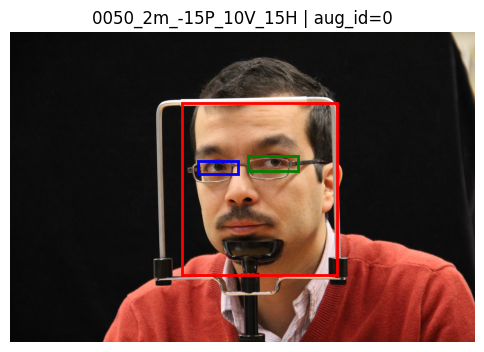

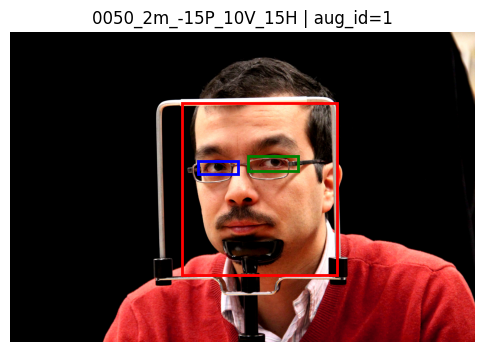

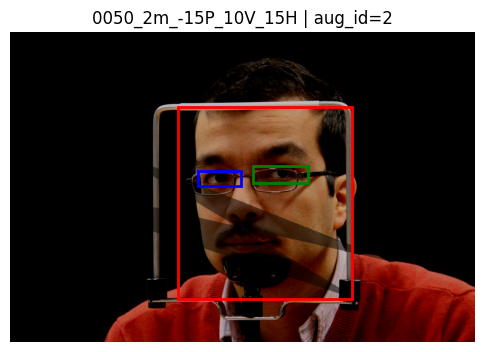

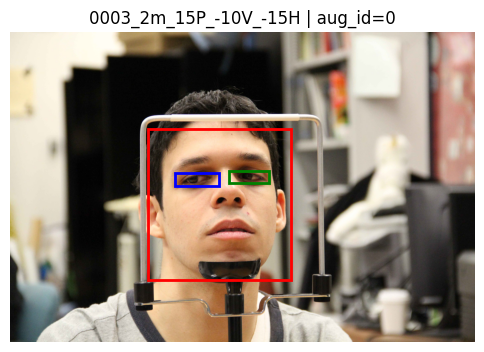

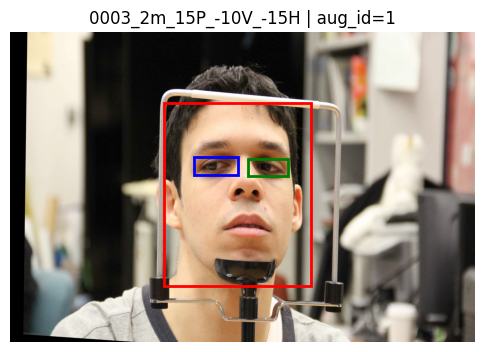

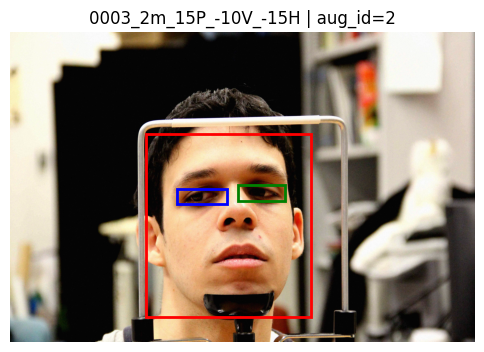

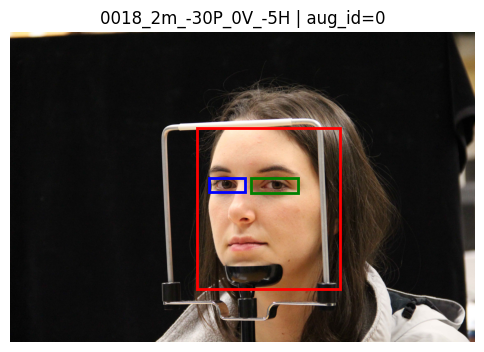

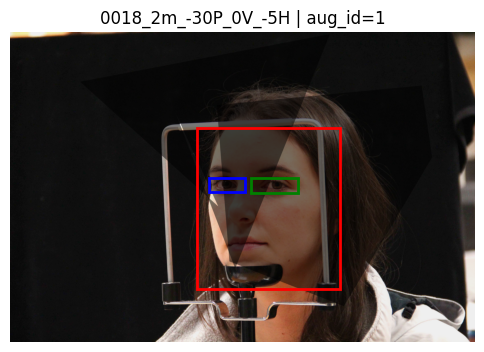

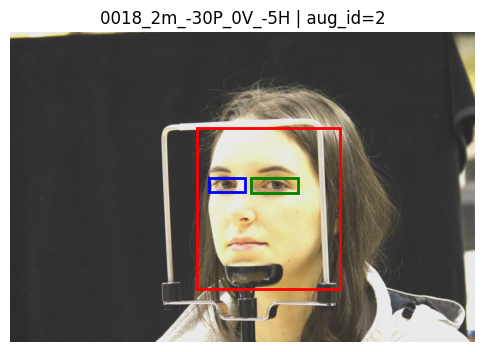


AUGMENTATION STATISTICS
Total augmentations: 6
Successful: 6 (100.0%)
Failed (used original): 0 (0.0%)


In [35]:
# Pass condition: boxes still sit on face and eyes for aug_id 1–2.
aug = build_replay_aug_in_the_wild()

stats = {'total': 0, 'successful': 0, 'failed': 0}

for rec in test_samples:
    img_np = np.array(Image.open(rec["path"]).convert("RGB"))
    stem = Path(rec["filename"]).stem

    for aug_id in range(0, K_test + 1):
        max_attempts = 10  # Try up to 10 times per augmentation
        found_valid = False
        
        for attempt in range(max_attempts):
            img_aug, face_b, left_b, right_b, replay = augment_full_and_bboxes(
                img_np,
                rec["face_bbox_px"],
                rec["left_bbox_px"],
                rec["right_bbox_px"],
                aug,
                aug_id
            )
            
            # Validate all three bounding boxes
            face_valid = is_bbox_valid(face_b, img_aug.shape, min_size=50)
            left_valid = is_bbox_valid(left_b, img_aug.shape, min_size=20)
            right_valid = is_bbox_valid(right_b, img_aug.shape, min_size=20)
            all_valid = face_valid and left_valid and right_valid
            
            # Accept if valid, or if it's the original (aug_id==0)
            if all_valid or aug_id == 0:
                found_valid = True
                if attempt > 0:
                    print(f"  ✓ Valid augmentation found on attempt {attempt + 1}/{max_attempts}")
                if aug_id > 0:
                    stats['successful'] += 1
                break
        else:
            # All attempts failed - fall back to original
            print(f"  ⚠️  WARNING: All {max_attempts} attempts failed for {stem}, aug_id={aug_id}")
            print(f"     Falling back to original image")
            img_aug = img_np
            face_b = rec["face_bbox_px"]
            left_b = rec["left_bbox_px"]
            right_b = rec["right_bbox_px"]
            if aug_id > 0:
                stats['failed'] += 1
        
        if aug_id > 0:
            stats['total'] += 1
        
        # # Your existing print statements
        # print(f"\n{stem} aug_id={aug_id}")
        # print("face", face_b)
        # print("left", left_b)
        # print("right", right_b)

        # Your existing visualization
        show_boxes(img_aug, face_b, left_b, right_b, title=f"{stem} | aug_id={aug_id}")

# Print final statistics
print("\n" + "="*60)
print("AUGMENTATION STATISTICS")
print("="*60)
print(f"Total augmentations: {stats['total']}")
print(f"Successful: {stats['successful']} ({stats['successful']/stats['total']*100:.1f}%)")
print(f"Failed (used original): {stats['failed']} ({stats['failed']/stats['total']*100:.1f}%)")
print("="*60)

In [36]:
def show_crops(face_crop, left_crop, right_crop, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(9,3))
    for ax, crop, name in zip(axes, [face_crop, left_crop, right_crop], ["face","left","right"]):
        ax.imshow(crop)
        ax.set_title(name)
        ax.axis("off")
    fig.suptitle(title)
    plt.show()


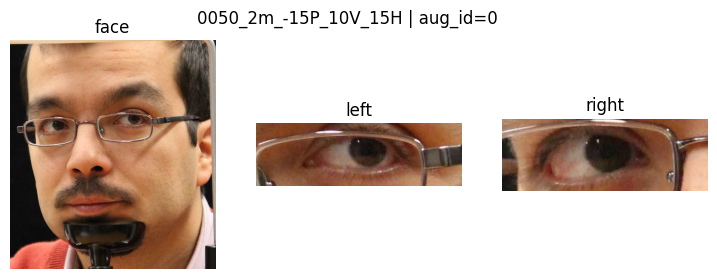

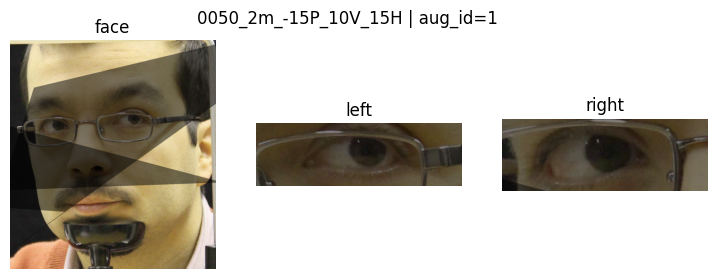

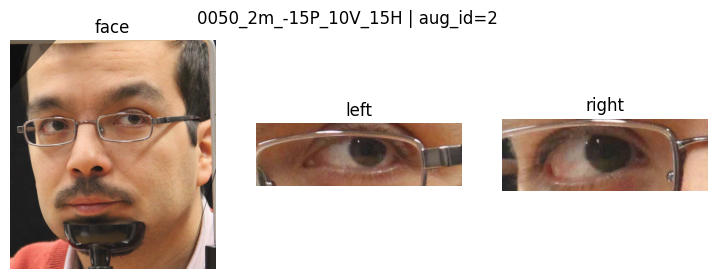

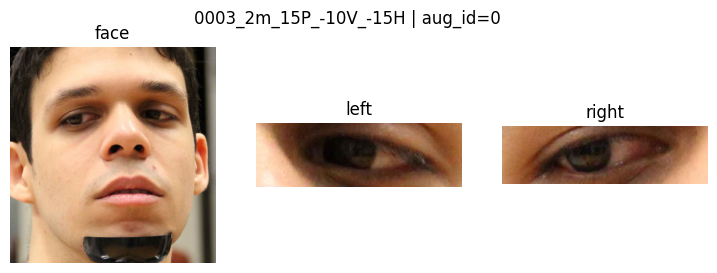

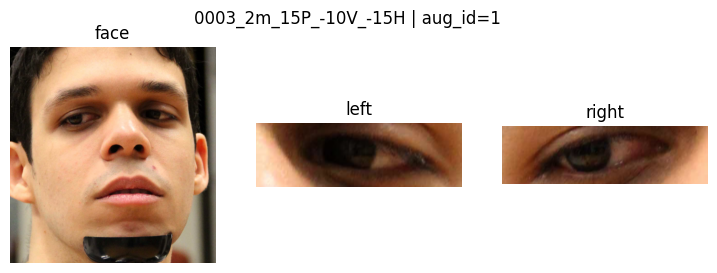

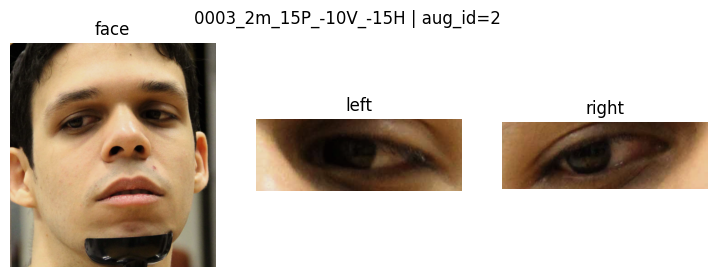

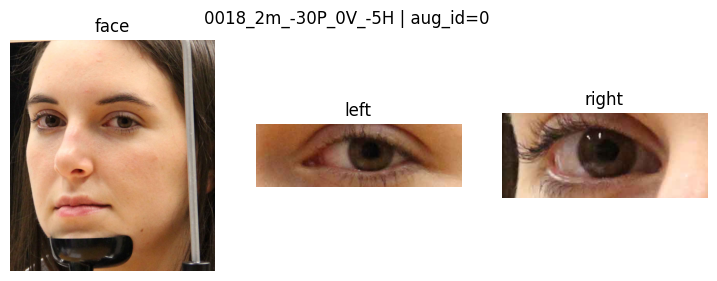

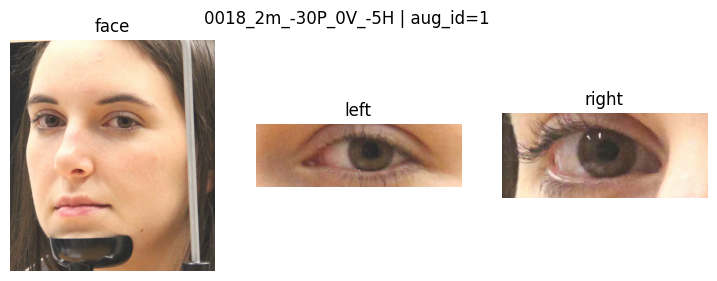

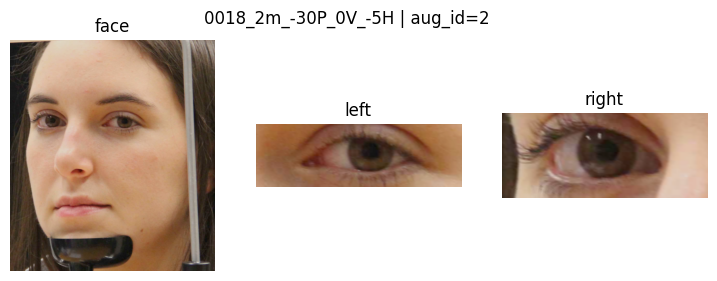

In [37]:
# Pass condition: you visually see a face crop and two eye crops, not random background.
for rec in test_samples:
    img_np = np.array(Image.open(rec["path"]).convert("RGB"))
    stem = Path(rec["filename"]).stem

    for aug_id in range(0, K_test + 1):
        img_aug, face_b, left_b, right_b, _ = augment_full_and_bboxes(
            img_np, rec["face_bbox_px"], rec["left_bbox_px"], rec["right_bbox_px"], aug, aug_id
        )

        face_crop = crop_from_bbox(img_aug, face_b, min_px=20)
        left_crop = crop_from_bbox(img_aug, left_b, min_px=20)
        right_crop = crop_from_bbox(img_aug, right_b, min_px=20)

        if face_crop is None or left_crop is None or right_crop is None:
            print("BAD CROP:", stem, "aug_id", aug_id)
            continue

        show_crops(face_crop, left_crop, right_crop, title=f"{stem} | aug_id={aug_id}")


In [38]:
# Save test: one sample to disk, verify shape + file exists
OUTPUT_ROOT_TEST = Path("/Volumes/Crucial X10/210/data/ceal_itracker_test_crops")
OUTPUT_ROOT_TEST.mkdir(parents=True, exist_ok=True)

rec = test_samples[0]
img_np = np.array(Image.open(rec["path"]).convert("RGB"))
stem = Path(rec["filename"]).stem

img_aug, face_b, left_b, right_b, _ = augment_full_and_bboxes(
    img_np, rec["face_bbox_px"], rec["left_bbox_px"], rec["right_bbox_px"], aug, aug_id=1
)

face_path, left_path, right_path, status, reason = crop_resize_save_triplet(
    img_aug, face_b, left_b, right_b,
    output_root=OUTPUT_ROOT_TEST,
    subject=rec["subject"],
    stem=stem,
    aug_id=1
)

print(status, reason, face_path, left_path, right_path)


ok None /Volumes/Crucial X10/210/data/ceal_itracker_test_crops/0050/0050_2m_-15P_10V_15H_aug1_face.jpg /Volumes/Crucial X10/210/data/ceal_itracker_test_crops/0050/0050_2m_-15P_10V_15H_aug1_left.jpg /Volumes/Crucial X10/210/data/ceal_itracker_test_crops/0050/0050_2m_-15P_10V_15H_aug1_right.jpg


In [39]:
# pass condition: Should print: (224, 224) (224, 224) (224, 224)
print(Image.open(face_path).size, Image.open(left_path).size, Image.open(right_path).size)


(224, 224) (224, 224) (224, 224)


## Step 2.4: Facegrid

Purpose: Provide the spatial prior used by iTracker’s FaceGrid pathway (FaceGridModel).  
This is consumed later in `data.py` and passed into `ITrackerModel(..., faceGrid)`.

**Inputs**
- `face_bbox_px` in **float** pixel coordinates on the **augmented full-frame** image:
  - `[x0, y0, x1, y1]`
- Full-frame image dimensions:
  - `img_w`, `img_h`
- `grid_size = 25`

**Procedure**
1) Project face bbox from pixel space → grid space (25×25)
   - Compute grid corners from the float bbox:
     - `gx0 = floor((x0 / img_w) * grid_size)`
     - `gy0 = floor((y0 / img_h) * grid_size)`
     - `gx1 = ceil ((x1 / img_w) * grid_size)`
     - `gy1 = ceil ((y1 / img_h) * grid_size)`
   - Clamp:
     - `gx0, gy0 ∈ [0, 24]`
     - `gx1, gy1 ∈ [1, 25]` (and ensure `gx1 > gx0`, `gy1 > gy0`)
   - Convert to iTracker-style grid params:
     - `grid_x = gx0`
     - `grid_y = gy0`
     - `grid_w = gx1 - gx0`
     - `grid_h = gy1 - gy0`

2) Rasterize grid params into a binary 25×25 mask
   - Initialize `grid = zeros((25,25), float32)`
   - Set rectangle to 1:
     - `grid[grid_y : grid_y + grid_h, grid_x : grid_x + grid_w] = 1.0`

3) Flatten to match model expectation
   - `facegrid_vec = grid.reshape(-1)` → shape `(625,)`, dtype `float32`

4) Save
   - `{OUTPUT_ROOT}/{subject}/{stem}_aug{aug_id}_facegrid.npy`

**Output**
- `facegrid_path` (points to a saved `(625,) float32` array)


In [40]:
GRID_SIZE = 25  # iTracker expects a 25x25 facegrid -> 625 vector

def facegrid_from_bbox(face_bbox_px, img_w, img_h, grid_size=GRID_SIZE):
    """
    Convert a face bounding box in full-frame pixel coordinates into an iTracker FaceGrid vector.

    Parameters
    ----------
    face_bbox_px : array-like
        Float pixel coords [x0, y0, x1, y1] for the face bbox on the augmented full-frame image.
        These should be in the same coordinate system as the augmented image (width=img_w, height=img_h).
    img_w : int
        Width of the augmented full-frame image in pixels.
    img_h : int
        Height of the augmented full-frame image in pixels.
    grid_size : int
        Size of the facegrid along one dimension. iTracker uses 25.

    Returns
    -------
    facegrid_vec : np.ndarray
        Flattened (grid_size*grid_size,) float32 vector with a rectangle of 1s indicating the face location.
        For iTracker this is shape (625,) dtype float32.
    """
    # Unpack bbox and cast to python floats to avoid dtype surprises
    x0, y0, x1, y1 = [float(v) for v in face_bbox_px]

    # 1) Project pixel-space bbox corners into grid-space corners
    #    gx0/gy0 use floor; gx1/gy1 use ceil, per spec.
    gx0 = int(np.floor((x0 / img_w) * grid_size))
    gy0 = int(np.floor((y0 / img_h) * grid_size))
    gx1 = int(np.ceil ((x1 / img_w) * grid_size))
    gy1 = int(np.ceil ((y1 / img_h) * grid_size))

    # 2) Clamp to valid grid indices/ranges
    #    Start indices must be within [0, grid_size-1] -> [0,24] for size 25
    gx0 = int(np.clip(gx0, 0, grid_size - 1))
    gy0 = int(np.clip(gy0, 0, grid_size - 1))

    #    End indices are allowed to equal grid_size (exclusive upper bound in slicing)
    #    Clamp to [1, grid_size] -> [1,25] for size 25
    gx1 = int(np.clip(gx1, 1, grid_size))
    gy1 = int(np.clip(gy1, 1, grid_size))

    # 3) Ensure non-empty rectangle (must have gx1>gx0 and gy1>gy0)
    #    If projection collapses due to rounding or extreme small boxes, force minimum width/height of 1 cell.
    if gx1 <= gx0:
        gx1 = min(grid_size, gx0 + 1)
    if gy1 <= gy0:
        gy1 = min(grid_size, gy0 + 1)

    # Convert corner representation into iTracker-style params
    grid_x = gx0
    grid_y = gy0
    grid_w = gx1 - gx0
    grid_h = gy1 - gy0

    # 4) Rasterize: binary mask with a 1-valued rectangle in the face region
    grid = np.zeros((grid_size, grid_size), dtype=np.float32)

    # Note: slicing is [start : start+size], end-exclusive, so gx1/gy1 being grid_size is valid.
    grid[grid_y : grid_y + grid_h, grid_x : grid_x + grid_w] = 1.0

    # 5) Flatten to match model expectation: (625,) float32 for 25x25
    facegrid_vec = grid.reshape(-1).astype(np.float32)

    return facegrid_vec


def save_facegrid(facegrid_vec, OUTPUT_ROOT, subject, stem, aug_id):
    """
    Save a facegrid vector to disk.

    File naming matches the crop naming convention:
      {OUTPUT_ROOT}/{subject}/{stem}_aug{aug_id}_facegrid.npy

    Parameters
    ----------
    facegrid_vec : np.ndarray
        (625,) float32 vector returned by facegrid_from_bbox.
    OUTPUT_ROOT : str or Path
        Root output directory for generated artifacts.
    subject : str
        Subject ID (directory name).
    stem : str
        Original filename stem (no extension).
    aug_id : int
        Augmentation index (0..K).

    Returns
    -------
    facegrid_path : str
        Path to the saved .npy file.
    """
    OUTPUT_ROOT = Path(OUTPUT_ROOT)
    subj_dir = OUTPUT_ROOT / str(subject)
    subj_dir.mkdir(parents=True, exist_ok=True)

    facegrid_path = subj_dir / f"{stem}_aug{aug_id}_facegrid.npy"

    # Ensure dtype is float32 for downstream model code
    np.save(facegrid_path, facegrid_vec.astype(np.float32))

    return str(facegrid_path)


(625,) float32 0.0 1.0 135.0


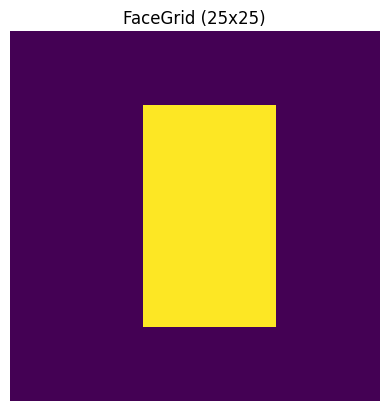

In [41]:
# test step 2.4
# pass conditions: Shape: (625,); Dtype: float32; min 0.0; max 1.0; sum > 0
# visual pass conditions: 
    # A rectangular block of 1’s
    # Properly contained within the 25×25 grid
    # Not touching weird edges
    # Not a single pixel wide
    # Not the entire grid

rec = bbox_records[0]  # or any known-good sample from Step 2.1
img_np = np.array(Image.open(rec["path"]).convert("RGB"))
h, w = img_np.shape[:2]
stem = Path(rec["filename"]).stem

# Use aug_id=0 identity first so bbox and image definitely match
facegrid_vec = facegrid_from_bbox(rec["face_bbox_px"], img_w=w, img_h=h)

print(facegrid_vec.shape, facegrid_vec.dtype, facegrid_vec.min(), facegrid_vec.max(), facegrid_vec.sum())

plt.imshow(facegrid_vec.reshape(25,25))
plt.title("FaceGrid (25x25)")
plt.axis("off")
plt.show()


## Step 2.5: Orchestration Layer + Manifest CSV 

For every successfully produced variant, append a row with:
- sample_id (unique)
- subject, orig_path, orig_filename
- aug_id
- face_path, left_path, right_path, facegrid_path
- head_pose_deg, gaze_v_deg, gaze_h_deg
- status="ok"

For failures, append rows with:
- subject, orig_path, aug_id
- status="fail"
- reason (no_face, bad_crop, etc.)

Write/append manifest to:
- {OUTPUT_ROOT}/manifest.csv

This manifest is the source of truth for data.py.

In [42]:
# manifest helpers

def make_sample_id(subject, stem, aug_id):
    """
    Deterministic unique ID for a produced variant.
    Stable across reruns as long as naming inputs are stable.
    """
    raw = f"{subject}|{stem}|{aug_id}"
    return hashlib.md5(raw.encode("utf-8")).hexdigest()

def ensure_manifest_header(manifest_path, fieldnames):
    """
    Create manifest file with header if it does not exist yet.
    """
    manifest_path = Path(manifest_path)
    manifest_path.parent.mkdir(parents=True, exist_ok=True)

    if not manifest_path.exists():
        with open(manifest_path, "w", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()


In [43]:
MANIFEST_FIELDS = [
    "sample_id",
    "subject",
    "orig_path",
    "orig_filename",
    "aug_id",
    "face_path",
    "left_path",
    "right_path",
    "facegrid_path",
    "head_pose_deg",
    "gaze_vertical_deg",
    "gaze_horizontal_deg",
    "status",
    "reason",
]

def run_pipeline_make_manifest(
    df,                      # dataframe from Step 2.0 (paths + metadata)
    bbox_lookup,             # dict: path -> {"face":..., "left":..., "right":...} float32 bboxes
    OUTPUT_ROOT,
    K,
    BATCH_SIZE=75,
    manifest_name="manifest.csv",
    min_crop_px=20,
    mode="overwrite",        # "overwrite" or "append"
):
    """
    Orchestrates Steps 2.2–2.4 and writes manifest rows (ok/fail).

    mode:
      - "overwrite": start fresh (write header, then rows)
      - "append": keep existing file; create+header if missing, then append rows
    """
    if mode not in {"overwrite", "append"}:
        raise ValueError(f"mode must be 'overwrite' or 'append' (got {mode!r})")

    OUTPUT_ROOT = Path(OUTPUT_ROOT)
    OUTPUT_ROOT.mkdir(parents=True, exist_ok=True)
    manifest_path = OUTPUT_ROOT / manifest_name

    # Build augmenter once and reuse (ReplayCompose includes randomness per call)
    aug = build_replay_aug_in_the_wild()

    # Decide file open mode + whether to write header
    if mode == "overwrite":
        file_mode = "w"
        write_header = True
    else:
        file_mode = "a"
        write_header = not manifest_path.exists()

    with open(manifest_path, file_mode, newline="") as f:
        writer = csv.DictWriter(f, fieldnames=MANIFEST_FIELDS)

        # Write header once (new file or overwrite)
        if write_header:
            writer.writeheader()

        for start in range(0, len(df), BATCH_SIZE):
            batch = df.iloc[start:start + BATCH_SIZE]

            for row in batch.itertuples(index=False):
                orig_path = row.path
                subject = row.subject
                orig_filename = row.filename
                stem = Path(orig_filename).stem

                # ---- Step 2.1 contract: bbox exists or fail out early ----
                if orig_path not in bbox_lookup:
                    writer.writerow({
                        "sample_id": "",
                        "subject": subject,
                        "orig_path": orig_path,
                        "orig_filename": orig_filename,
                        "aug_id": 0,
                        "face_path": "",
                        "left_path": "",
                        "right_path": "",
                        "facegrid_path": "",
                        "head_pose_deg": getattr(row, "head_pose_deg", ""),
                        "gaze_vertical_deg": getattr(row, "gaze_vertical_deg", ""),
                        "gaze_horizontal_deg": getattr(row, "gaze_horizontal_deg", ""),
                        "status": "fail",
                        "reason": "no_face",  # could also be "missing_bbox"
                    })
                    continue

                face_bbox = bbox_lookup[orig_path]["face"]
                left_bbox = bbox_lookup[orig_path]["left"]
                right_bbox = bbox_lookup[orig_path]["right"]

                # Load original image once per source
                img_np = np.array(Image.open(orig_path).convert("RGB"))
                img_h, img_w = img_np.shape[:2]

                # ---- Step 2.2–2.4 per augmentation variant ----
                for aug_id in range(0, K + 1):
                    sample_id = make_sample_id(subject, stem, aug_id)

                    # Step 2.2: augment full image + bboxes consistently
                    img_aug, face_b, left_b, right_b, replay = augment_full_and_bboxes(
                        img_np, face_bbox, left_bbox, right_bbox, aug, aug_id
                    )

                    # Step 2.3: crop + resize + save triplet
                    face_path, left_path, right_path, status, reason = crop_resize_save_triplet(
                        img_aug, face_b, left_b, right_b,
                        output_root=OUTPUT_ROOT,
                        subject=subject,
                        stem=stem,
                        aug_id=aug_id,
                        min_px=min_crop_px,
                    )

                    if status != "ok":
                        writer.writerow({
                            "sample_id": sample_id,
                            "subject": subject,
                            "orig_path": orig_path,
                            "orig_filename": orig_filename,
                            "aug_id": aug_id,
                            "face_path": "",
                            "left_path": "",
                            "right_path": "",
                            "facegrid_path": "",
                            "head_pose_deg": row.head_pose_deg,
                            "gaze_vertical_deg": row.gaze_vertical_deg,
                            "gaze_horizontal_deg": row.gaze_horizontal_deg,
                            "status": "fail",
                            "reason": reason or "bad_crop",
                        })
                        continue

                    # Step 2.4: facegrid from augmented face bbox (full-frame coords)
                    facegrid_vec = facegrid_from_bbox(face_b, img_w=img_w, img_h=img_h, grid_size=GRID_SIZE)
                    facegrid_path = save_facegrid(facegrid_vec, OUTPUT_ROOT, subject, stem, aug_id)

                    writer.writerow({
                        "sample_id": sample_id,
                        "subject": subject,
                        "orig_path": orig_path,
                        "orig_filename": orig_filename,
                        "aug_id": aug_id,
                        "face_path": face_path,
                        "left_path": left_path,
                        "right_path": right_path,
                        "facegrid_path": facegrid_path,
                        "head_pose_deg": row.head_pose_deg,
                        "gaze_vertical_deg": row.gaze_vertical_deg,
                        "gaze_horizontal_deg": row.gaze_horizontal_deg,
                        "status": "ok",
                        "reason": "",
                    })

    return str(manifest_path)


In [44]:
# Build bbox_lookup from Step 2.1 results
bbox_lookup = {
    rec["path"]: {
        "face": rec["face_bbox_px"],
        "left": rec["left_bbox_px"],
        "right": rec["right_bbox_px"],
    }
    for rec in bbox_records
}


In [45]:
# smoke test
OUTPUT_ROOT_TEST = Path("/Volumes/Crucial X10/210/data/ceal_itracker_artifacts_test")
df_test = df.sample(10, random_state=42).reset_index(drop=True)

manifest_path = run_pipeline_make_manifest(
    df=df_test,
    bbox_lookup=bbox_lookup,
    OUTPUT_ROOT=OUTPUT_ROOT_TEST,
    K=2,
    BATCH_SIZE=75,
)

print("Wrote manifest:", manifest_path)

Wrote manifest: /Volumes/Crucial X10/210/data/ceal_itracker_artifacts_test/manifest.csv


In [46]:
# check test results
# pass condistions:
    # len(m) == 30
    # status contains mostly "ok"
    # failures are allowed, but shouldn’t be like 29/30 unless something is broken
m = pd.read_csv(manifest_path)
m["status"].value_counts()
m.head()

,sample_id,subject,orig_path,orig_filename,aug_id,face_path,left_path,right_path,facegrid_path,head_pose_deg,gaze_vertical_deg,gaze_horizontal_deg,status,reason
0,719c1ed692f9036053135feec1e8acc8,47,/Volumes/Crucial X10/210/data/columbia_gaze_da...,0047_2m_0P_10V_-15H.jpg,0,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,0,10,-15,ok,NaN
1,8bd8b98ed3aff7d6892671e1c1cc3c85,47,/Volumes/Crucial X10/210/data/columbia_gaze_da...,0047_2m_0P_10V_-15H.jpg,1,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,0,10,-15,ok,NaN
2,72d0ad7555dc45bbbfca42a924f2f3e5,47,/Volumes/Crucial X10/210/data/columbia_gaze_da...,0047_2m_0P_10V_-15H.jpg,2,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,0,10,-15,ok,NaN
3,65b89c9d6cdcb3eb79f86f6399cd3df5,40,/Volumes/Crucial X10/210/data/columbia_gaze_da...,0040_2m_-30P_-10V_0H.jpg,0,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,-30,-10,0,ok,NaN
4,f115e6780fc329fb6bb110f59a419a9c,40,/Volumes/Crucial X10/210/data/columbia_gaze_da...,0040_2m_-30P_-10V_0H.jpg,1,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,/Volumes/Crucial X10/210/data/ceal_itracker_ar...,-30,-10,0,ok,NaN


In [47]:
# check test results
# pass condistions: Missing cols: []
required_cols = [
    "sample_id","subject","orig_path","orig_filename","aug_id",
    "face_path","left_path","right_path","facegrid_path",
    "head_pose_deg","gaze_vertical_deg","gaze_horizontal_deg",
    "status","reason"
]

missing = [c for c in required_cols if c not in m.columns]
print("Missing cols:", missing)


Missing cols: []


In [48]:
# check test results
# pass condition: all false
ok = m[m["status"] == "ok"]

print("OK rows:", len(ok))
print("Any missing paths?",
      ok[["face_path","left_path","right_path","facegrid_path"]].isna().any().to_dict())

OK rows: 30
Any missing paths? {'face_path': False, 'left_path': False, 'right_path': False, 'facegrid_path': False}


In [49]:
# check test results
# pass condition: each should be N/N where N = number of ok rows.

def pct_exists(paths):
    paths = [p for p in paths if isinstance(p, str) and p.strip()]
    return sum(Path(p).exists() for p in paths), len(paths)

for col in ["face_path","left_path","right_path","facegrid_path"]:
    n_exist, n_total = pct_exists(ok[col].tolist())
    print(col, f"{n_exist}/{n_total} exist")


face_path 30/30 exist
left_path 30/30 exist
right_path 30/30 exist
facegrid_path 30/30 exist


In [50]:
# check test results
# pass condition: 224, 224) for all three.

sample_row = ok.sample(1, random_state=0).iloc[0]

print("face:", Image.open(sample_row["face_path"]).size)
print("left:", Image.open(sample_row["left_path"]).size)
print("right:", Image.open(sample_row["right_path"]).size)


face: (224, 224)
left: (224, 224)
right: (224, 224)


In [51]:
# check test results
# pass condition: 
    # shape (625,)
    # dtype float32
    # values in {0,1} (min 0 max 1)
    # sum > 0

fg = np.load(sample_row["facegrid_path"])
print("facegrid:", fg.shape, fg.dtype, fg.min(), fg.max(), fg.sum())

facegrid: (625,) float32 0.0 1.0 126.0


In [52]:
# check test results
# pass condition: 
    # 0: 10
    # 1: 10
    # 2: 10
    # If one aug_id is missing entirely, your loop logic is broken.
print(m["aug_id"].value_counts().sort_index())

aug_id
0    10
1    10
2    10
Name: count, dtype: int64


In [ ]:
# FULL RUN - PROCEED WITH CAUTION
OUTPUT_ROOT = Path("/Volumes/Crucial X10/210/data/ceal_itracker_artifacts")

# overwrite (fresh run)
# manifest_path = run_pipeline_make_manifest(df, bbox_lookup, OUTPUT_ROOT, K=num_augs, mode="overwrite")

# append (resume/extend)
# manifest_path = run_pipeline_make_manifest(df, bbox_lookup, OUTPUT_ROOT, K=num_augs, mode="append")

/opt/anaconda3/envs/itracker/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [54]:
m = pd.read_csv("/Volumes/Crucial X10/210/data/ceal_itracker_artifacts/manifest.csv")

print("Total rows:", len(m))
print("Status breakdown:\n", m["status"].value_counts())
print("Aug distribution:\n", m["aug_id"].value_counts().sort_index())


Total rows: 23520
Status breakdown:
 status
ok    23520
Name: count, dtype: int64
Aug distribution:
 aug_id
0    5880
1    5880
2    5880
3    5880
Name: count, dtype: int64


In [55]:
row = m[m["status"] == "ok"].sample(1, random_state=1).iloc[0]

print("Face size:", Image.open(row["face_path"]).size)
print("Left size:", Image.open(row["left_path"]).size)
print("Right size:", Image.open(row["right_path"]).size)

fg = np.load(row["facegrid_path"])
print("Facegrid:", fg.shape, fg.dtype, fg.min(), fg.max(), fg.sum())

Face size: (224, 224)
Left size: (224, 224)
Right size: (224, 224)
Facegrid: (625,) float32 0.0 1.0 135.0


## Step 2.6: Downstream contract for inference (data.py alignment)
data.py will:
- read manifest.csv
- load face/left/right crops as PIL
- apply preprocessing expected by pretrained checkpoint:
  - Resize(224,224) -> ToTensor -> SubtractMean(using mean images)
- load facegrid.npy (625,) float32
- return (sample_id, face, left, right, facegrid)

Labels are not required for inference. Parsed degrees remain in manifest for evaluation later.